# Importing required packages 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import preprocessing
import sys
sys.path.append("../src/")
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


%matplotlib inline

# Loading dataframe used in modeling 

In [142]:
city = 'cambridge'

In [148]:
df = pd.read_csv('../data_zips/data/cambridge/processed/vz_predict_dataset.csv.gz')
#df = pd.read_csv('../data/{}/processed/vz_predict_dataset.csv.gz'.format(city))

In [149]:
df.width.describe()

count    770800.000000
mean         14.626862
std           7.281311
min           0.000000
25%          12.000000
50%          13.000000
75%          18.000000
max          46.000000
Name: width, dtype: float64

In [4]:
m = pickle.load(open('../data/boston/processed/model.pkl', 'rb'))

In [80]:
# changing speed: speeds > 30, down to 30
features = m.get_booster().feature_names
speed_features = [f for f in features if f.find('SPEED')!=-1]
speed_df = df.copy(deep=True)
speed_df.loc[speed_df.SPEEDLIMIT>20, speed_features] = 0
speed_df.loc[speed_df.SPEEDLIMIT>20, 'SPEEDLIMIT20'] = 1
preds = m.predict_proba(df[features])[::,1]
preds_speed = m.predict_proba(speed_df[features])[::,1]
preds_df = pd.DataFrame([preds, preds_speed]).T
speed_df['predicted'] = preds_speed
speed_df.to_csv('../data/boston/processed/seg_w_predicted_speed20.csv', index=False)

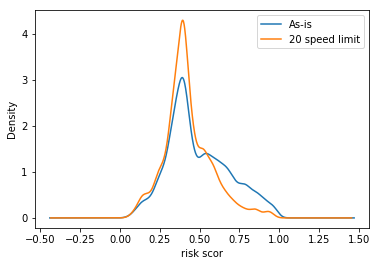

In [76]:
p = preds_df.plot(kind='kde')
p.set_xlabel('risk scor')
p.legend(labels=['As-is','20 speed limit'])

### Selecting a subset of columns which we will use in further analysis

In [135]:
city_columns = {'boston':['AADT', 'SPEEDLIMIT', 'Struct_Cnd', 
                          'Surface_Tp', 'F_F_Class', 'visionzero', 
                          'speed_coalesced', 'volume_coalesced',
                          'Conflict', 'intersection'],
               'cambridge':['lanes', 'hwy_type', 'osm_speed', 'oneway',
                           'signal', 'seeclickfix', 'width'],
                'dc':['lanes', 'hwy_type', 'osm_speed', 'oneway',
                           'signal']}

In [141]:
city_columns[city]

['lanes', 'hwy_type', 'osm_speed', 'oneway', 'signal']

In [133]:
df_minimal_columns = df[city_columns[city]].fillna(0)

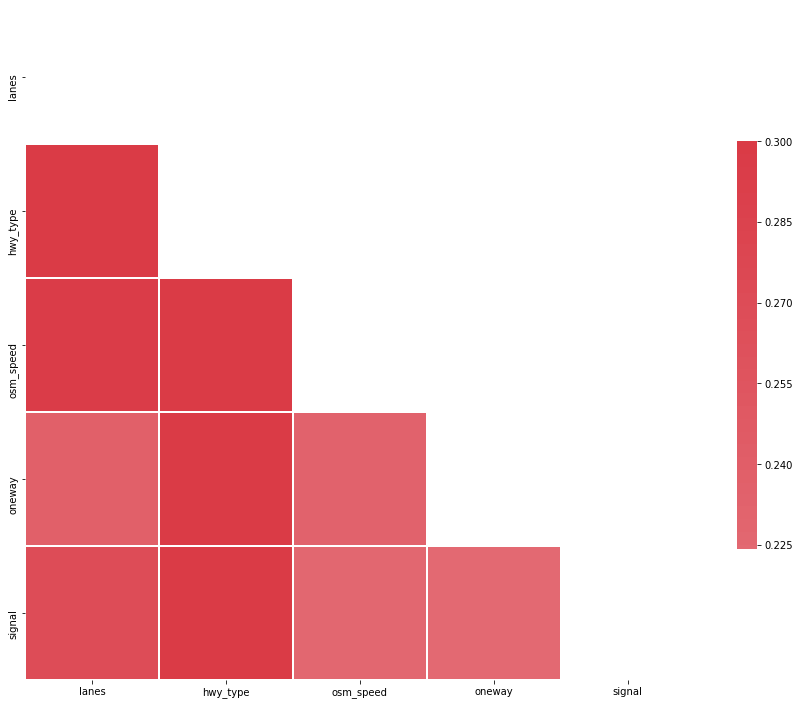

In [136]:
corr = df_minimal_columns.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Apply PCA

In [137]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [88]:
df_input = df_minimal_columns.fillna(0)
pca = TSNE(n_components=2,random_state=12345)
# make pipeline
pipe = make_pipeline(StandardScaler(), pca)
pipe.fit(df_input)
pca_result = pipe.fit_transform(df_input)


In [138]:
df_input = df_minimal_columns.fillna(0)
pca = PCA(n_components=4,random_state=12345)
# make pipeline
pipe = make_pipeline(StandardScaler(), pca)
pipe.fit(df_input)
pca_result = pipe.fit_transform(df_input)


In [139]:
def pca_results(good_data, pca):
# adapted from: https://github.com/viktortnk/udacity-ml/blob/master/projects/creating_customer_segments/renders.py
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Create a bar plot visualization
	fig, ax = plt.subplots(figsize = (16,10))

	# Plot the feature weights as a function of the components
	colors = ['r','g','b','y','m','k','c']*2
	components.plot(ax = ax, kind = 'bar', color=colors)
	ax.set_ylabel("Feature Weights")
	ax.set_xticklabels(dimensions, rotation=0)


	# Display the explained variance ratios
	for i, ev in enumerate(pca.explained_variance_ratio_):
		ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)

,Explained Variance,lanes,hwy_type,osm_speed,oneway,signal
Dimension 1,0.4592,0.4629,0.5466,0.4308,0.4044,0.3712
Dimension 2,0.1595,-0.0183,-0.1990,-0.3150,-0.2051,0.9049
Dimension 3,0.1567,0.3468,0.0240,0.4147,-0.8402,-0.0338
Dimension 4,0.1405,-0.6888,-0.1246,0.6827,0.0409,0.2056


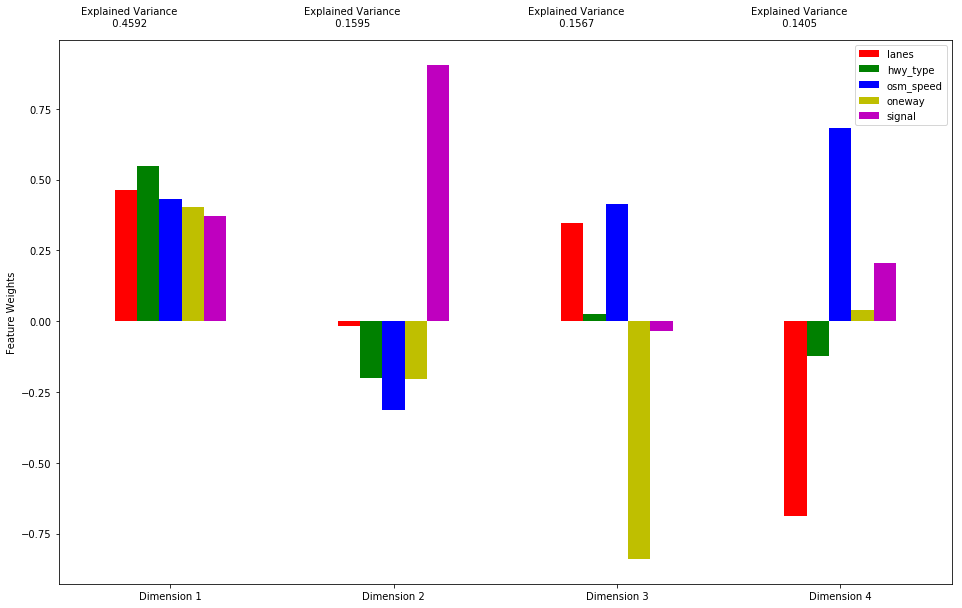

In [140]:
pca_results(df_input, pipe.named_steps.pca)

### High risk (red) and Non high risk segments plotted
High risk = Prediction above a threshold.  Here I use 75 to more clearly indicate highest risk

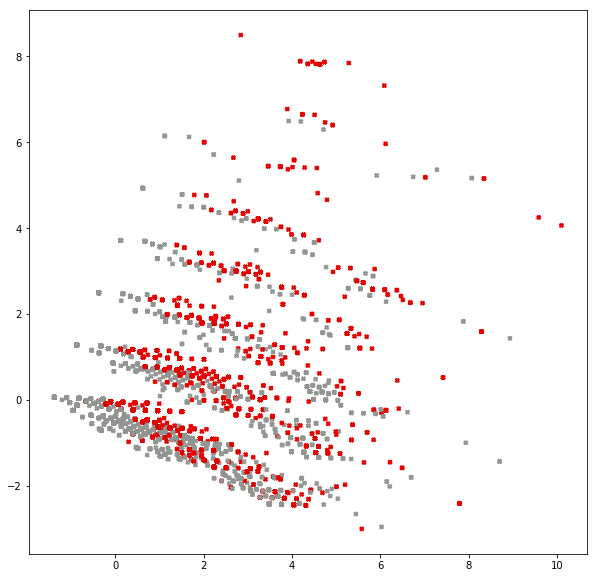

In [112]:
plt.figure(figsize=[10,10])
color_mapping = {False: sns.xkcd_rgb['grey'], True: sns.xkcd_rgb['red']}
colors = list(map(lambda x: color_mapping[x], df.prediction>.75))
plt.scatter(
        pca_result[:,0],
        pca_result[:,1],
        s=16,
        marker="X", c = colors)

# Applying KMeans Clustering and trying to list out characteristics of each cluster

In [113]:
def evaluate_clusters(X,max_clusters):
    error = np.zeros(max_clusters+1)
    error[0] = 0;
    for k in range(1,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        error[k] = kmeans.inertia_

    plt.plot(range(1,len(error)),error[1:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Error')

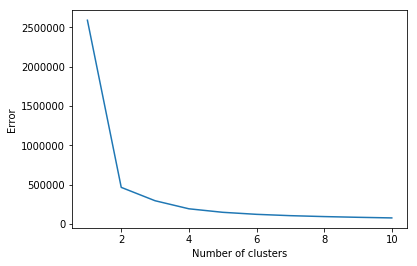

In [114]:
# X_scale = preprocessing.normalize(df_minimal_columns, norm='l2')
evaluate_clusters(df_minimal_columns.fillna(0),10)
plt.show()

In [115]:
from sklearn.cluster import KMeans

#INTEGER FOR RANDOM SEEDING 
random_state = 170

n_clusters = 2

y_pred = KMeans(n_clusters=n_clusters, init='k-means++',random_state=random_state).fit_predict(df_minimal_columns)
cluster_labels = y_pred

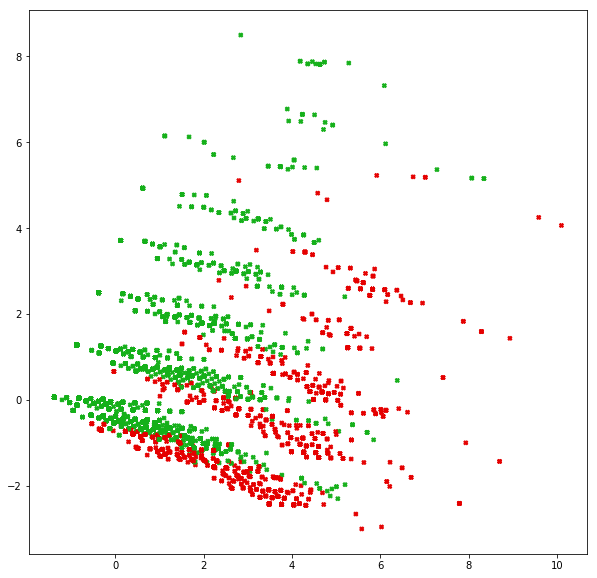

In [116]:
plt.figure(figsize=[10,10])
#vis_x_filtered = vis_x[]
color_mapping = {0: sns.xkcd_rgb['green'], 1: sns.xkcd_rgb['red'], 2: sns.xkcd_rgb['blue'], 3: sns.xkcd_rgb['yellow'], 4: sns.xkcd_rgb['grey']}
colors = list(map(lambda x: color_mapping[x], cluster_labels))
plt.scatter(
        pca_result[:,0],
        pca_result[:,1],
        s=16,
        marker="X",
        c = colors
        )

In [117]:
df_minimal_columns['cluster_label'] =  cluster_labels

## Find key characteristics of these clusters
- top features which are different in the given cluster when compared with the rest of the clusters
- select those specific features to explain the characteristics of the clusters

In [118]:
from sklearn.feature_selection import SelectPercentile,f_classif
from sklearn.model_selection import train_test_split


def get_top_features_from_dataset(data, cluster_labels,n_clusters=3):

    temp_labels = []
    dataset = data.as_matrix()
    labels = set(cluster_labels)
    for label in labels:
        revised_labels = pd.Series(cluster_labels)        
        revised_labels = revised_labels.apply(lambda x: 1 if x == label else 0)
        
        X_train, X_test, y_train, y_test = train_test_split(dataset, revised_labels.as_matrix(),random_state=0,test_size=1)
        fscore = f_classif(X_train,y_train)

        top_feature_set = {
            "cluster_label": str(label),
            "names" : list(data.columns.values),
            "scores" : fscore[0].tolist(),
            "pvalues" : fscore[1].tolist()               
        }    
    
        temp_labels.append(top_feature_set)

    return temp_labels

In [119]:
for result in get_top_features_from_dataset(df_minimal_columns, cluster_labels,n_clusters):
    #Get top values of pvalues
    top_5_p_values_indices = np.argsort(result['pvalues'])[0:10]
    cluster_df = df_minimal_columns[df_minimal_columns['cluster_label'] == int(result['cluster_label'])]
    
    print("\n\nCluster : %s"%str(result['cluster_label']))
    print("-------")
    print("Mean crashes: %1.5f" % df.target.loc[cluster_df.index].mean())
    print("Characteristics of cluster %s"%str(result['cluster_label']))
    
    tmp_df = pd.DataFrame(columns=['feature_name','mean in cluster','mean (overall)','proportion ratio'])
    
    for index in range(len(df_minimal_columns.columns)):
        name = result['names'][index]
        tmp_df= tmp_df.append({
            'feature_name': name  ,
            'mean in cluster': cluster_df[name].mean() ,
            'mean (overall)': df_minimal_columns[name].mean(),
            'proportion ratio': cluster_df[name].mean() / df_minimal_columns[name].mean()
        },ignore_index=True)

        
    print(tmp_df.to_string(index=False))
    



Cluster : 0
-------
Mean crashes: 0.53350
Characteristics of cluster 0
feature_name  mean in cluster  mean (overall)  proportion ratio
        lanes         1.398662        1.559958          0.896602
     hwy_type         1.667482        2.066706          0.806831
    osm_speed         0.065645        3.121280          0.021031
       oneway         0.351488        0.383651          0.916166
       signal         0.234525        0.282592          0.829906
cluster_label         0.000000        0.089744          0.000000


Cluster : 1
-------
Mean crashes: 0.56861
Characteristics of cluster 1
feature_name  mean in cluster  mean (overall)  proportion ratio
        lanes         3.195949        1.559958          2.048740
     hwy_type         6.115949        2.066706          2.959274
    osm_speed        34.113924        3.121280         10.929468
       oneway         0.709873        0.383651          1.850312
       signal         0.770127        0.282592          2.725225
cluster_lab

/Users/B/anaconda/envs/mainpy3/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/B/anaconda/envs/mainpy3/lib/python3.6/site-packages/ipykernel/__main__.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/B/anaconda/envs/mainpy3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
